<a href="https://colab.research.google.com/github/winterspriggan/11_Camera/blob/master/GTSRB_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Import From https://www.kaggle.com/code/sairama03/gtsrb-cnn
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gtsrb-german-traffic-sign:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F82373%2F191501%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240530%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240530T011229Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D316861b1695082eda902ecbedd5f9aea26414c8e548276589c06bbb266484d8ef68e539b22b1243612401231e3e82157b22c025c17609f89991df6ce6b0e7829ec7ede39ec55bf057438350dc1b8310f0299de836220d710320644735181b1397877bee550ce3df7c29490b07a958aa01b99227139c630515ae195868ae7adbfcff717489672194d2d80e5f582d8bf83bd705085e08652d8bf8b919c8f3ed616fefa1f3d8925203a66311254f3840483afc9111f81126a21ecc1ee7db4bf531654df892bea848aaea7e3629720d43b0f7ade8efea07632310306b37587e7a2c1498f55452a6e1af3599cae7d804108760f44dc384459a41210c4c03d1a82ec1a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 641568792 bytes downloaded
Downloaded and uncompressed: gtsrb-german-traffic-sign
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [3]:
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [4]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

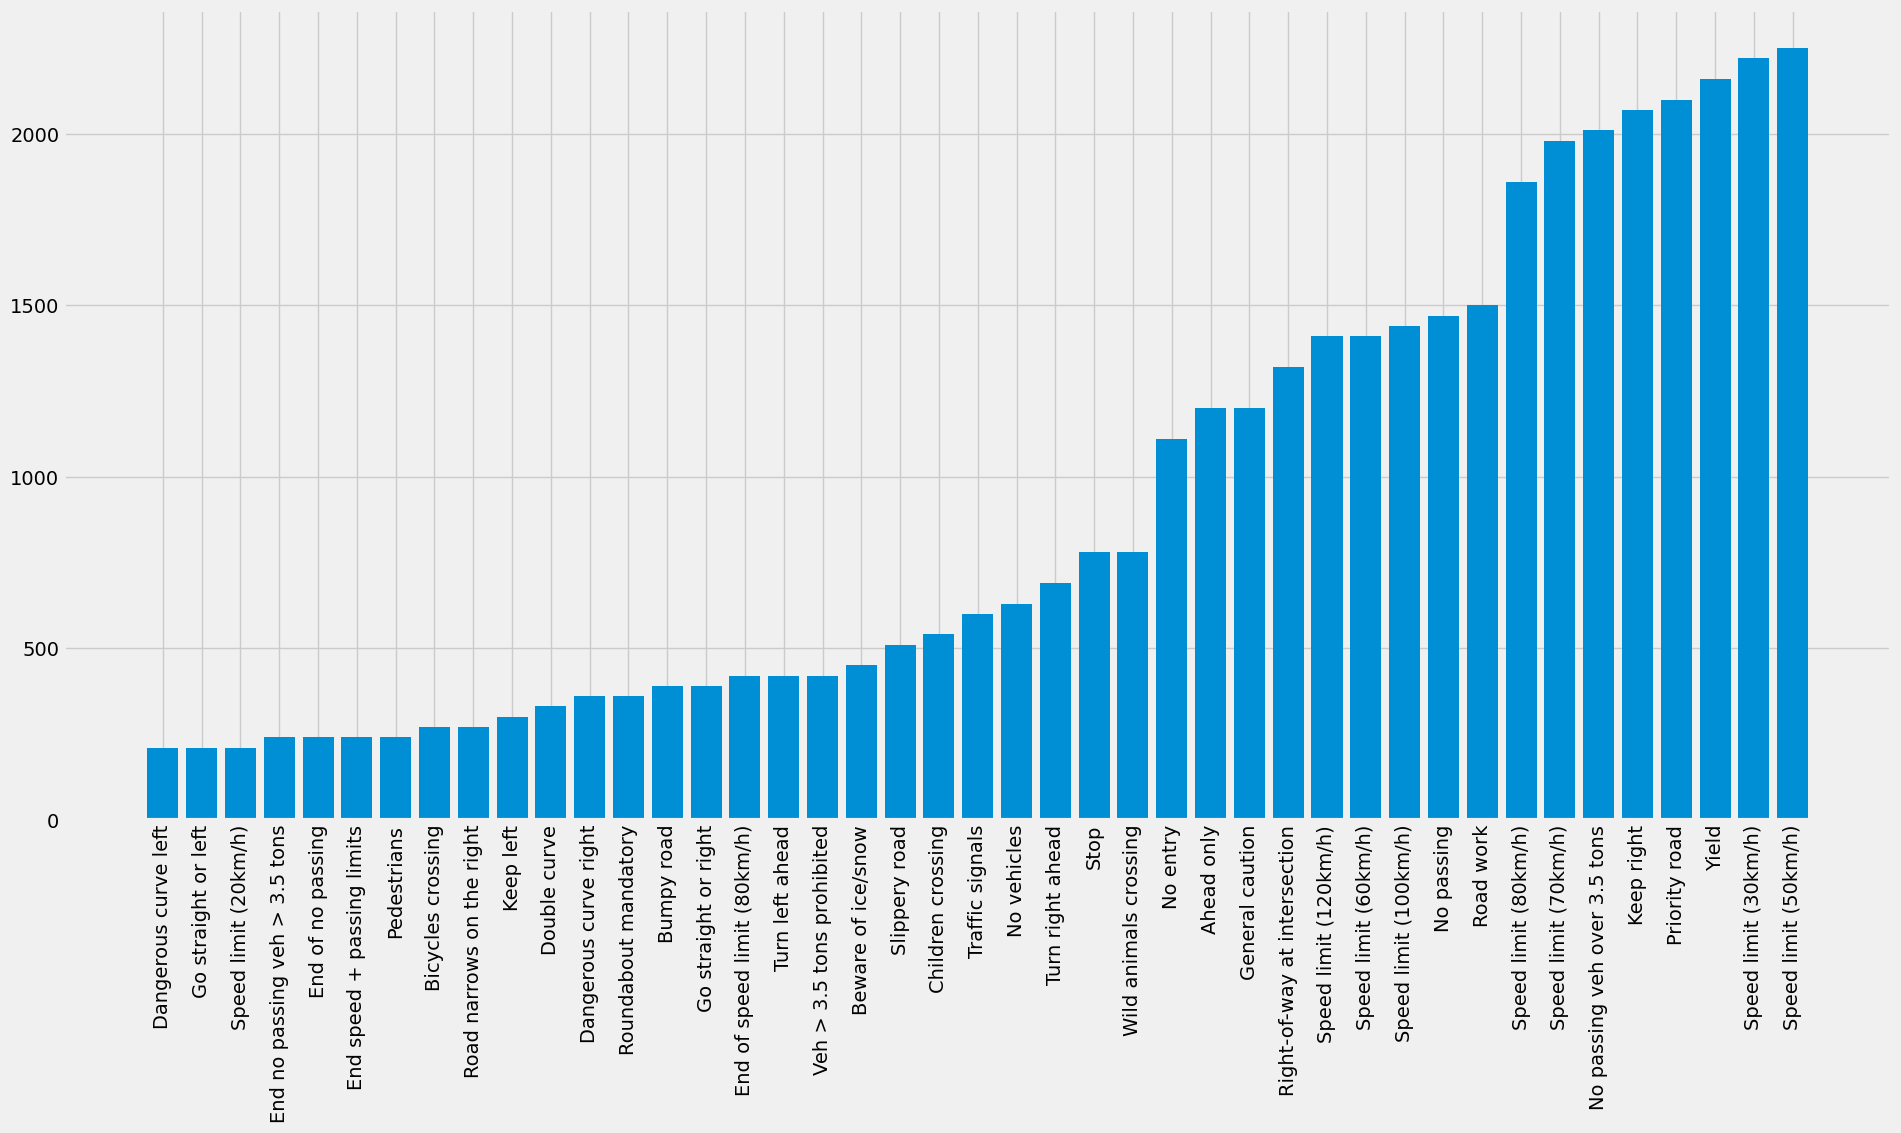

In [6]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

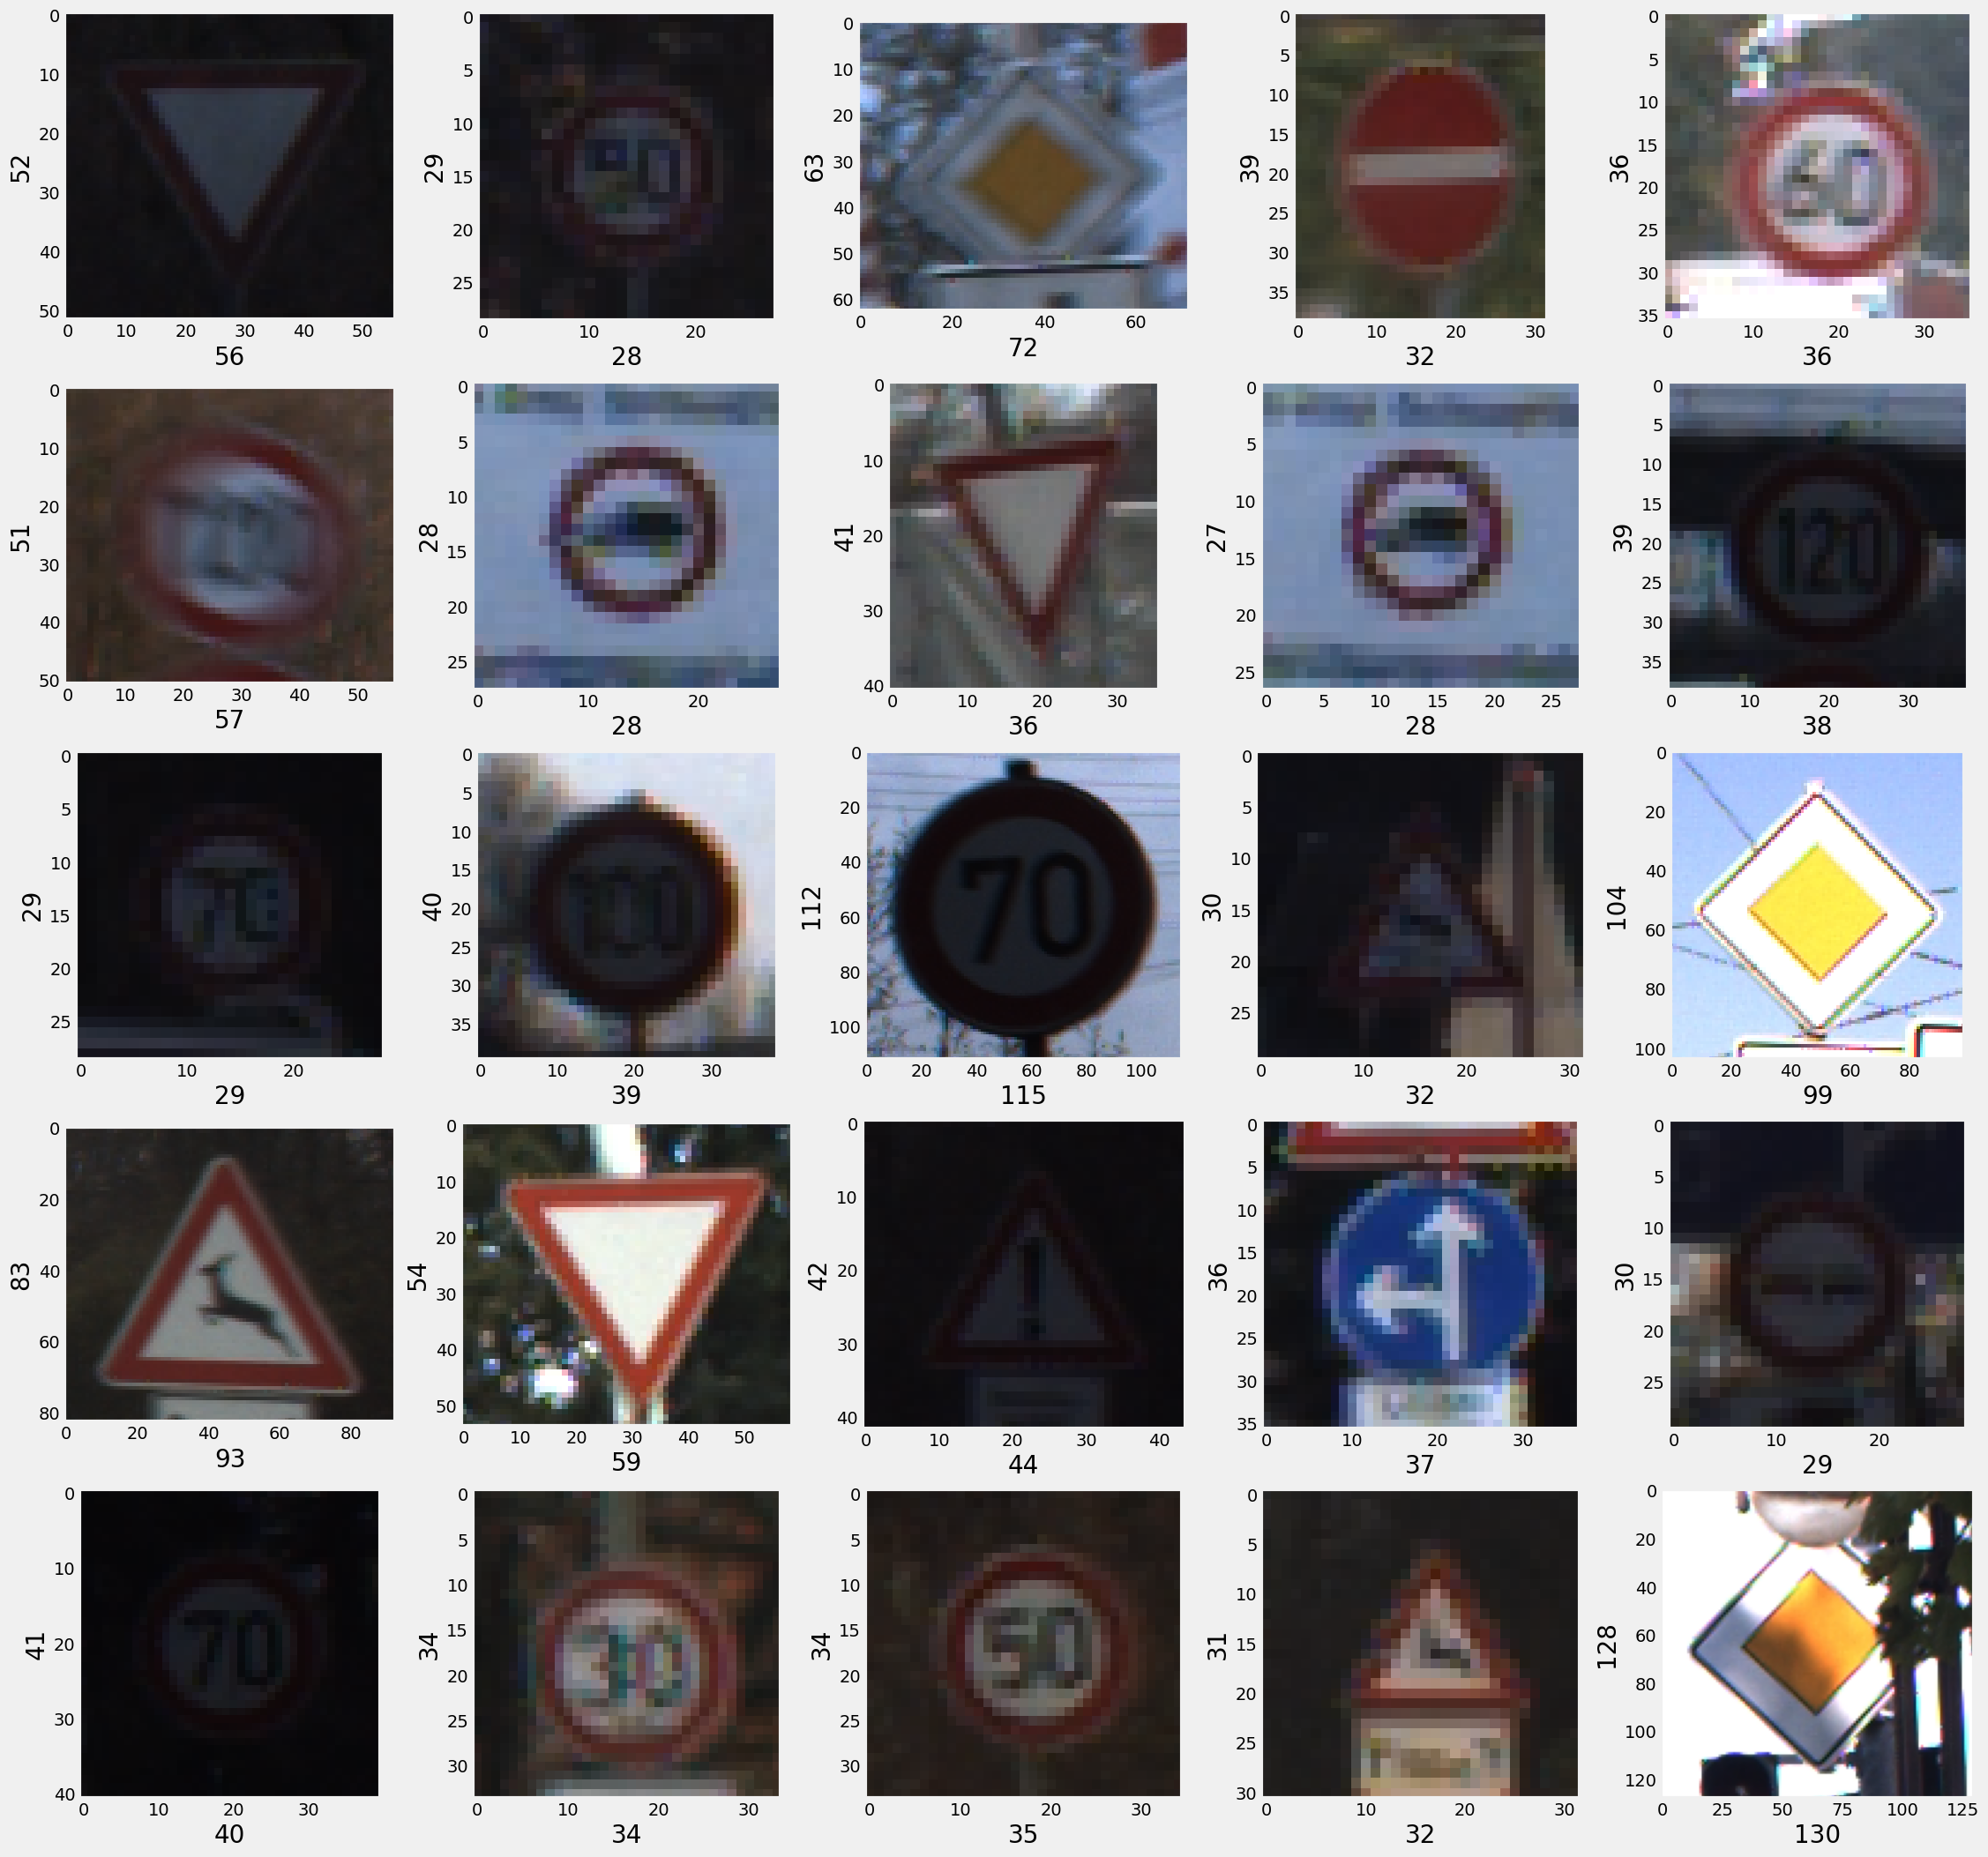

In [8]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(None) # Remove the invalid 'b' argument
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [9]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [10]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [11]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [12]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [13]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

In [17]:
lr = 0.001
epochs = 3

opt = Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [18]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/3
858/858 [==============================] - 135s 155ms/step - loss: 0.2532 - accuracy: 0.9234 - val_loss: 0.0522 - val_accuracy: 0.9855
Epoch 2/3
858/858 [==============================] - 118s 138ms/step - loss: 0.1129 - accuracy: 0.9653 - val_loss: 0.0261 - val_accuracy: 0.9922
Epoch 3/3
858/858 [==============================] - 114s 133ms/step - loss: 0.0918 - accuracy: 0.9722 - val_loss: 0.0593 - val_accuracy: 0.9802


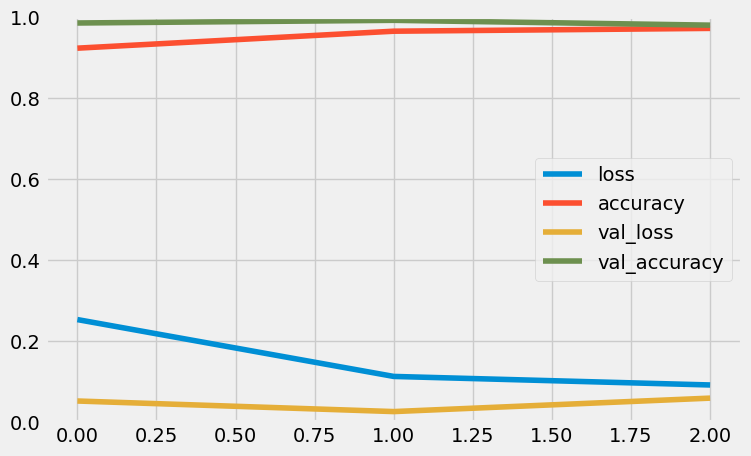

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [21]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = np.argmax(model.predict(X_test), axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 12s 29ms/step
Test Data accuracy:  94.48139350752177


In [22]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<Axes: >

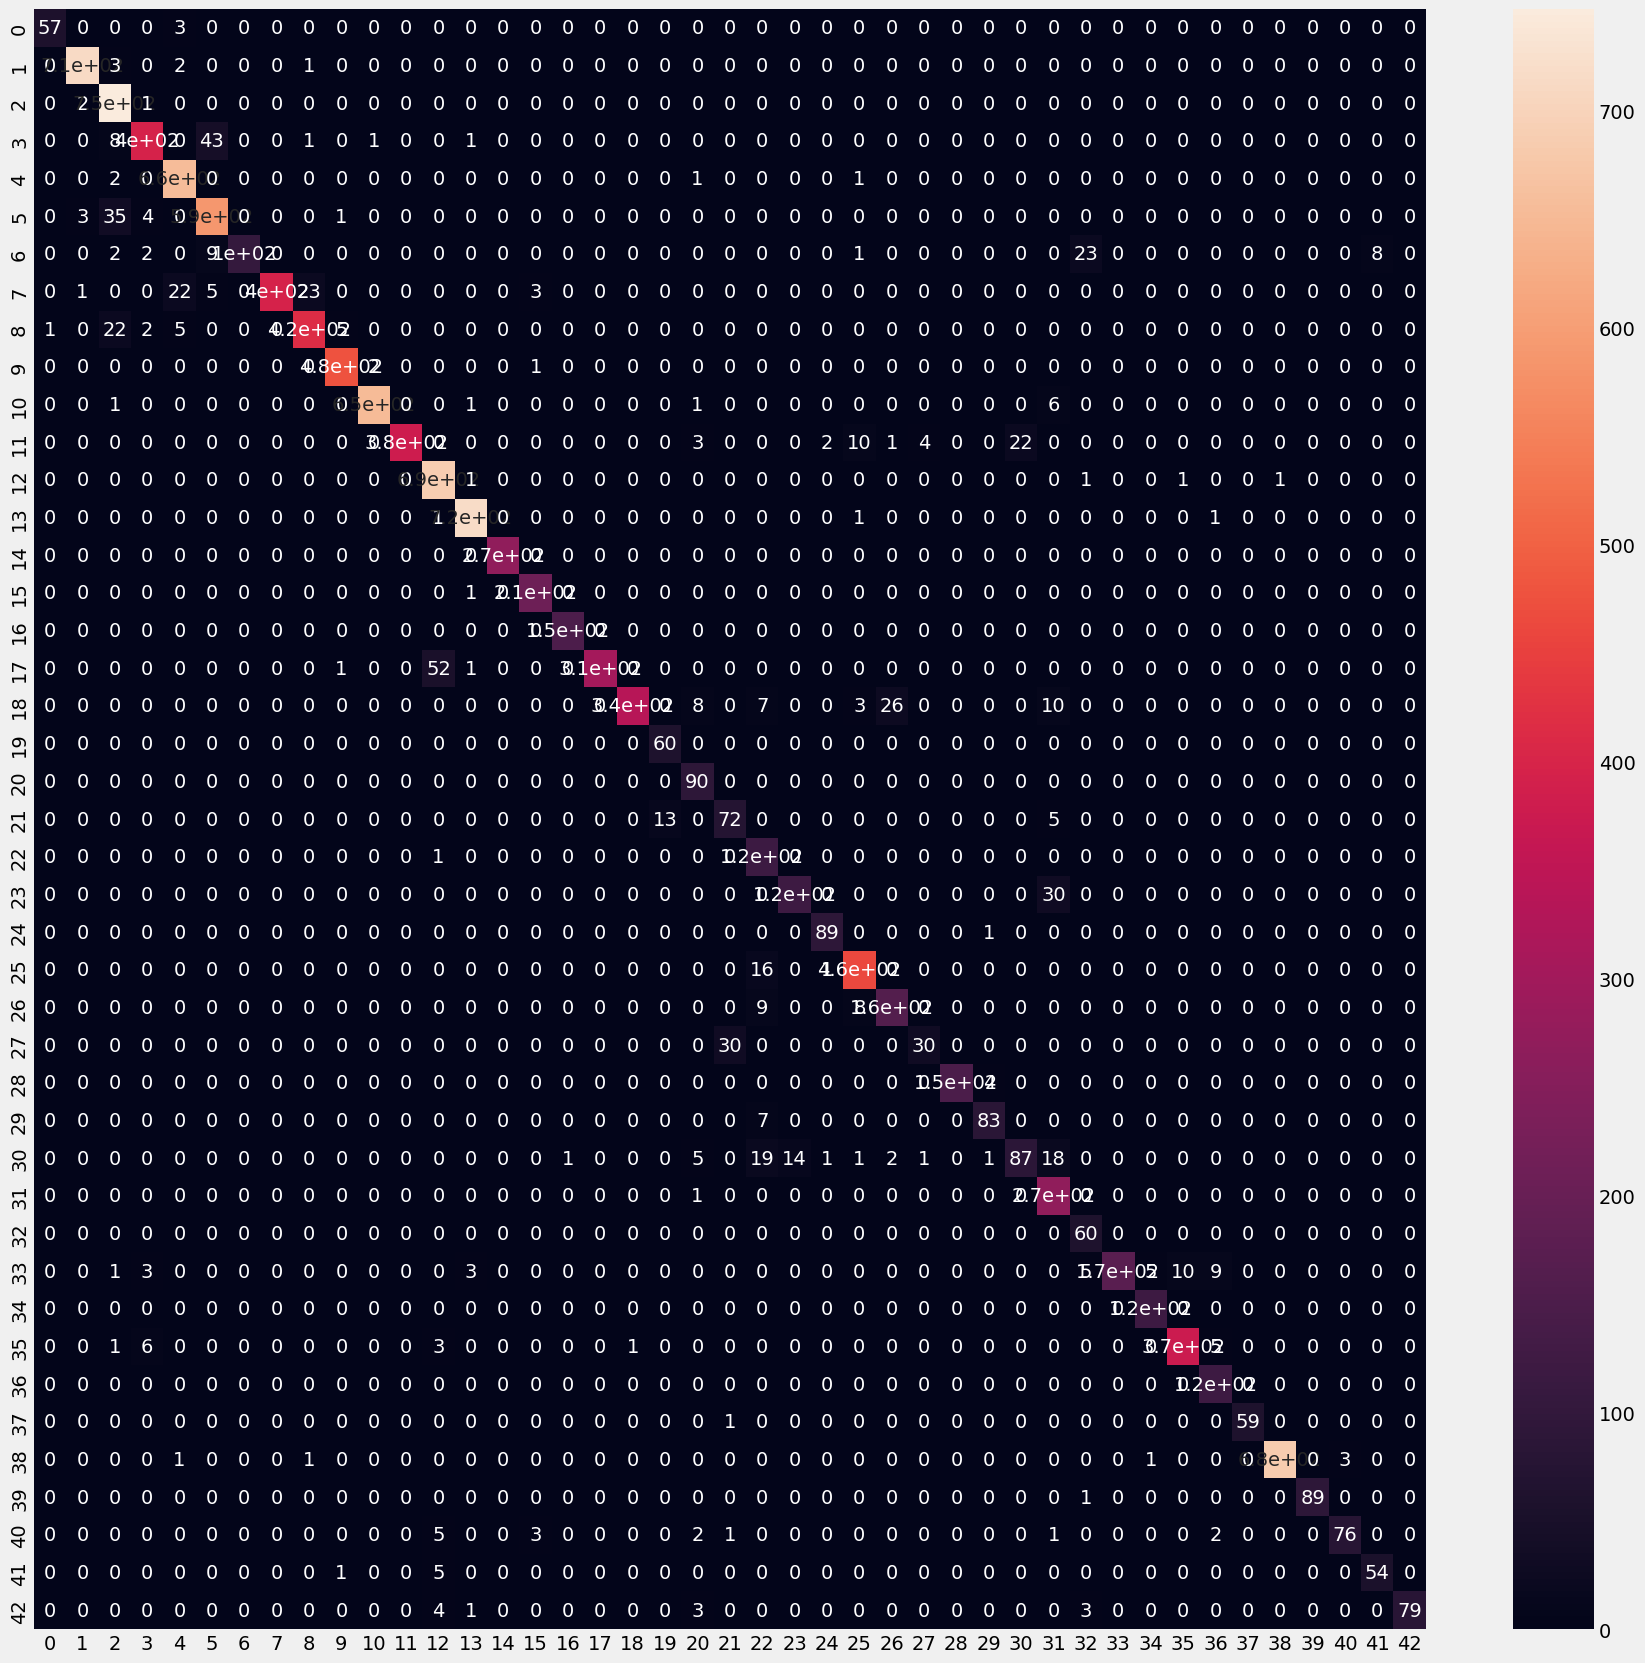

In [23]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [24]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        60
           1       0.99      0.99      0.99       720
           2       0.91      1.00      0.95       750
           3       0.96      0.88      0.92       450
           4       0.95      0.99      0.97       660
           5       0.91      0.93      0.92       630
           6       1.00      0.70      0.82       150
           7       1.00      0.88      0.94       450
           8       0.94      0.92      0.93       450
           9       0.98      0.99      0.99       480
          10       1.00      0.99      0.99       660
          11       1.00      0.90      0.95       420
          12       0.91      0.99      0.95       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.98       210
          16       0.99      1.00      1.00       150
          17       1.00    

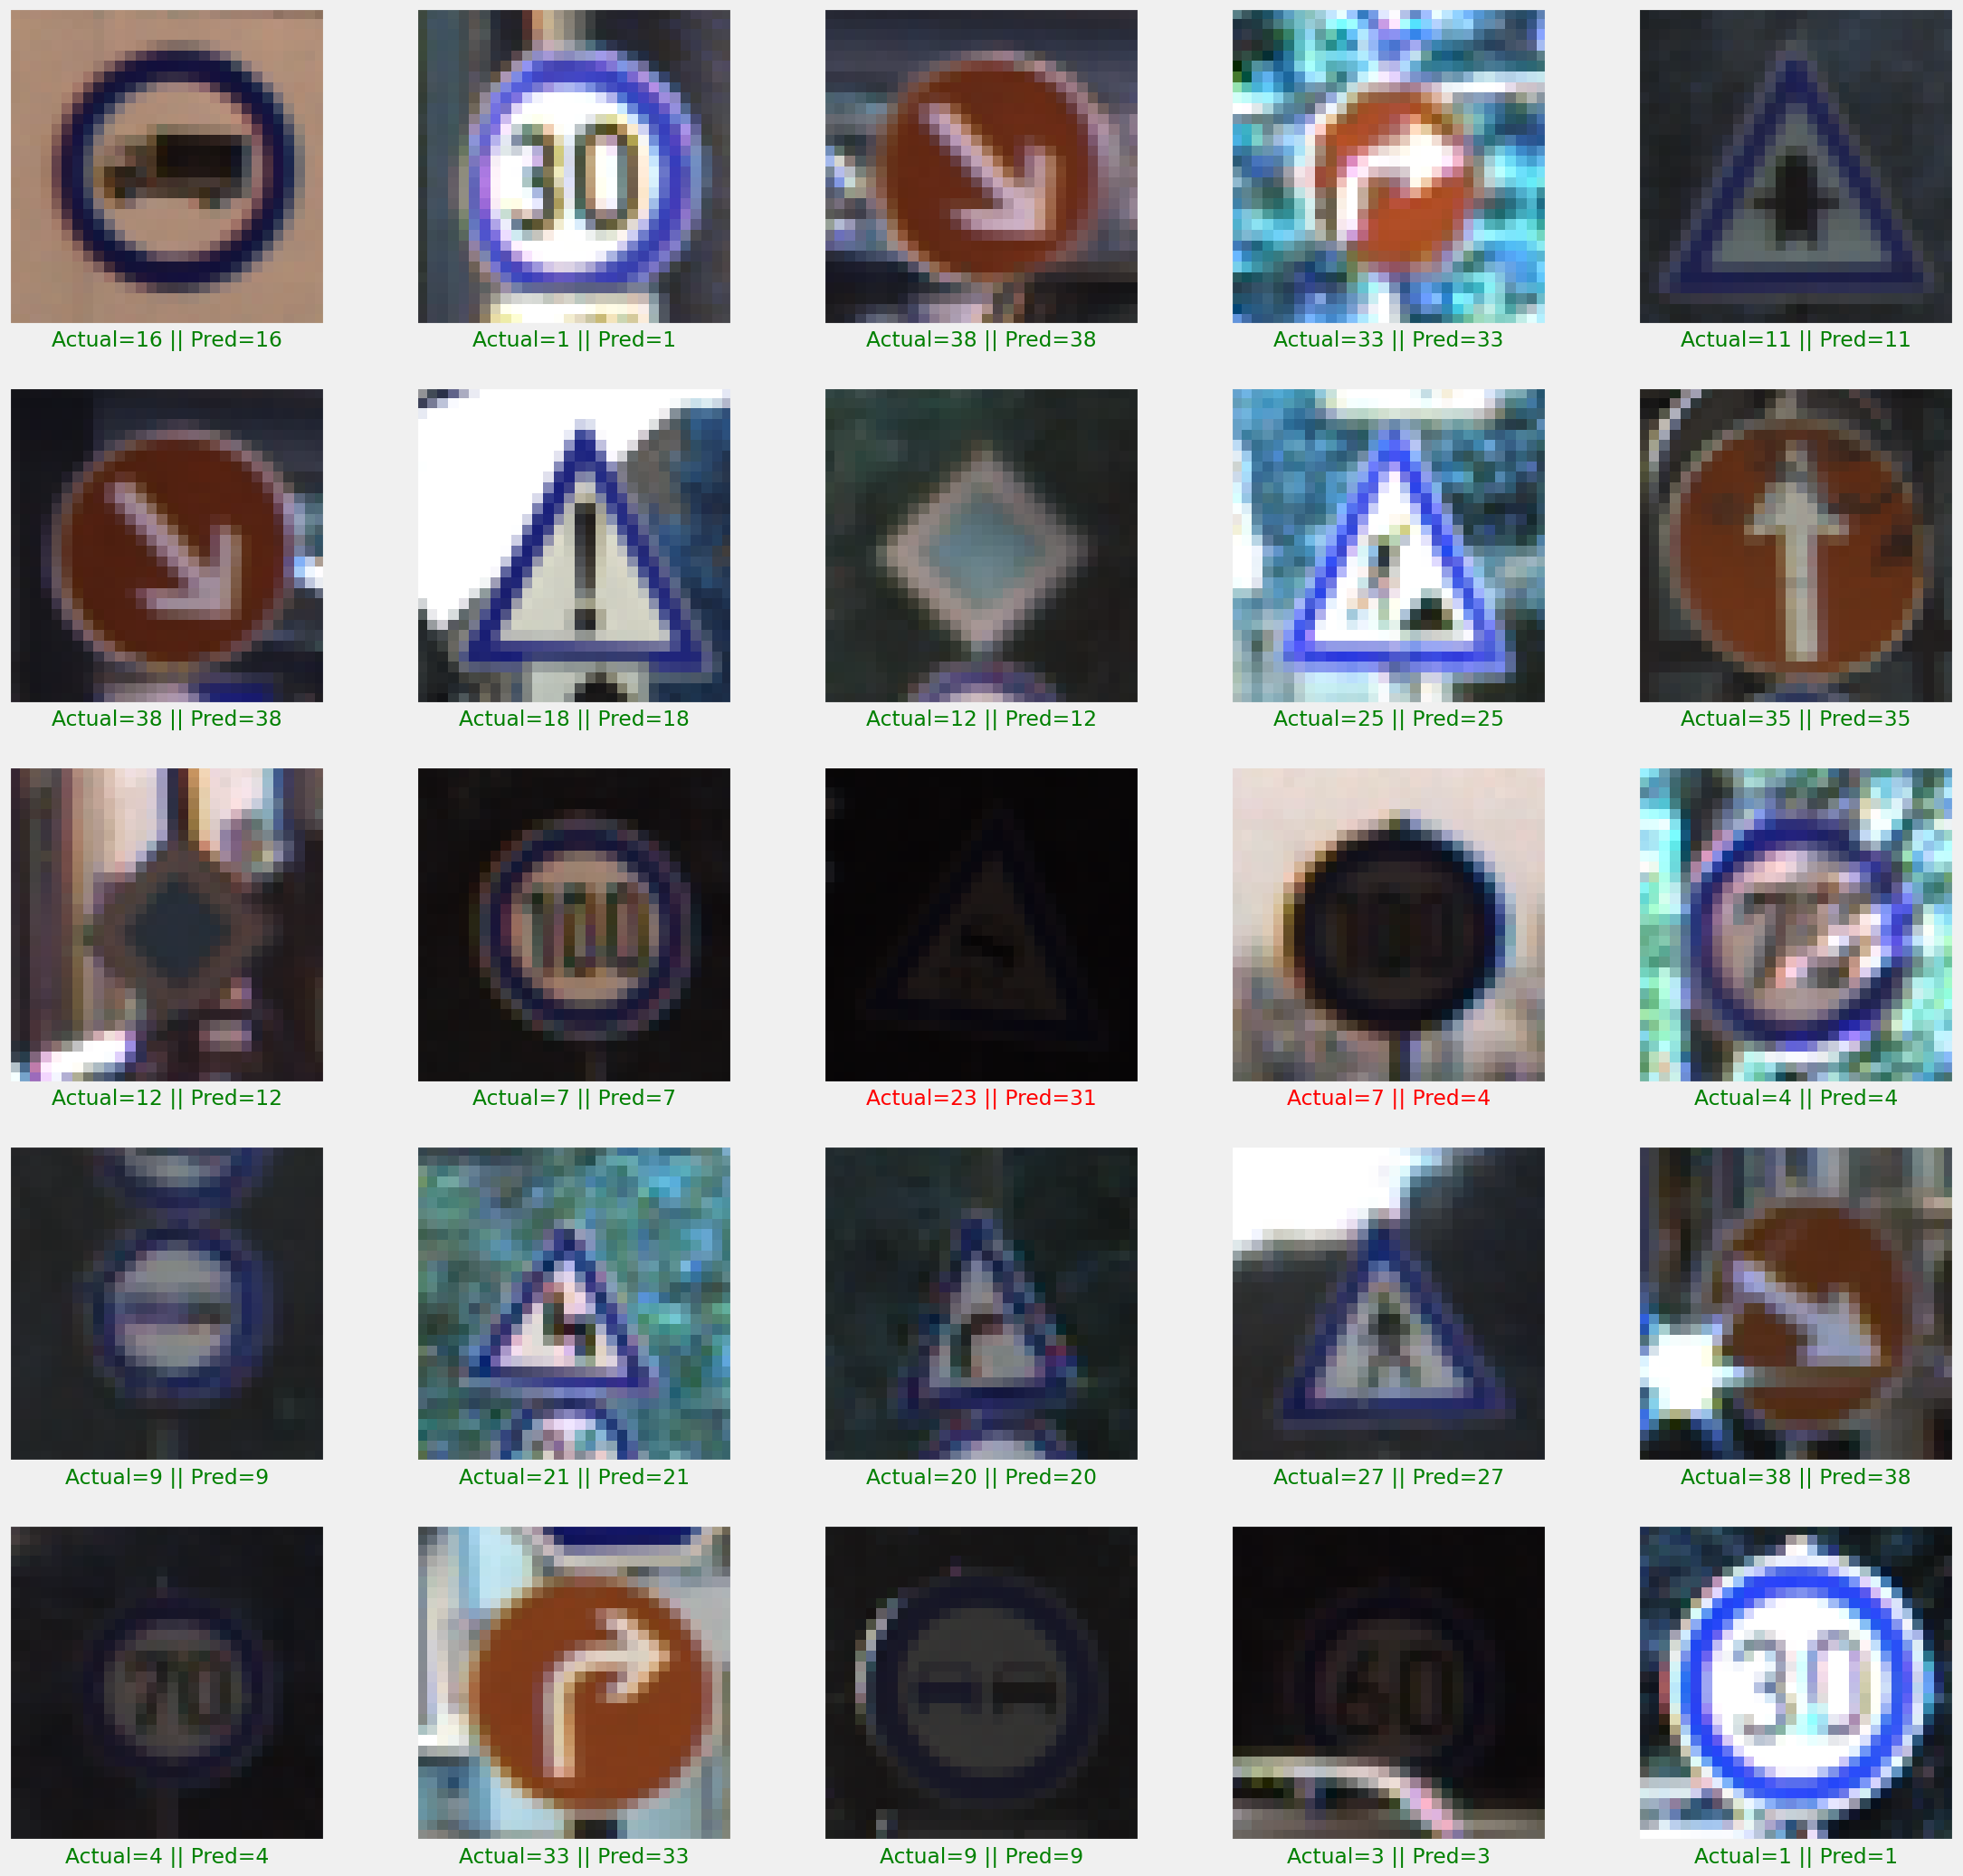

In [25]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()